In [1]:
import numpy as np
import itertools
from scipy.sparse.csr import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# `2 Applied ML`

## `2(1)`

### `Load the` *`20newsgroup`*  `Dataset`

In [3]:
newsgroup = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

print("%d documents" % len(newsgroup.filenames))
print("%d categories" % len(newsgroup.target_names))

11314 documents
20 categories


### `Compute vectors using TF-IDF scores`

In [4]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroup.data)

print("%d vectors" % len(vectors.todense()))

11314 vectors


### `Pair category of each article`

In [5]:
catregory_ref = dict()
for i,k  in enumerate(newsgroup['target_names']):
    catregory_ref[k] = i

In [6]:
extract_category = lambda filename: catregory_ref[filename.split("/")[6]]
category_func = np.vectorize(extract_category)
category = np.transpose(csr_matrix(category_func(newsgroup['filenames'])))

### `Split the data into train, validation and test sets`

In [7]:
x = vectors
y = category
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.11)

print("%d articles in train dataset" % len(x_train.todense()))
print("%d articles in validation dataset" % len(x_validation.todense()))
print("%d articles in test dataset" % len(x_test.todense()))


9061 articles in train dataset
1121 articles in validation dataset
1132 articles in test dataset


## `2(2)`

In [8]:
def random_forest_accuracy(x_train, y_train, x_validation, y_validation, max_depth, n_estimators):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    clf.fit(x_train.todense(), np.ravel(y_train.todense()))
    
    return accuracy_score(y_validation.todense(), clf.predict(x_validation.todense()))

### `Grid search on` *`max_depth`* `and` *`n_estimators`*

In [9]:
n_estimators_list = [70,90,110]
max_depth_list = [70,90,110]

best_param = {'n_estimators': 0,
              'max_depth': 0}

max_acc = 0.

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        acc = random_forest_accuracy(x_train, y_train, x_validation, y_validation, max_depth, n_estimators)
        print("Accuracy = %f for n_estimators = %d, max_depth = %d"%(acc,n_estimators,max_depth))
        if acc > max_acc:
            max_acc = acc
            best_param['n_estimators'] = n_estimators
            best_param['max_depth'] = max_depth

print('The best accuracy score %f is obtained by parameters %s.'%(max_acc,str(best_param)))

Accuracy = 0.640500 for n_estimators = 70, max_depth = 70
Accuracy = 0.623550 for n_estimators = 70, max_depth = 90
Accuracy = 0.617306 for n_estimators = 70, max_depth = 110
Accuracy = 0.631579 for n_estimators = 90, max_depth = 70
Accuracy = 0.638715 for n_estimators = 90, max_depth = 90
Accuracy = 0.649420 for n_estimators = 90, max_depth = 110
Accuracy = 0.633363 for n_estimators = 110, max_depth = 70
Accuracy = 0.647636 for n_estimators = 110, max_depth = 90
Accuracy = 0.647636 for n_estimators = 110, max_depth = 110
The best accuracy score 0.649420 is obtained by parameters {'n_estimators': 90, 'max_depth': 110}.


##  `Alternative method to find best parameters using` *`scikit-learn`*

### `Load the` *`20newsgroup`*  `Dataset`

In [15]:
newsgroup = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

print("%d documents" % len(newsgroup.filenames))
print("%d categories" % len(newsgroup.target_names))

11314 documents
20 categories


### `Create pipeline with` *`TfidfVectorizer()`* `and` *`RandomForestClassifier()`*

In [10]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),
])

### `Grid search on` *`max_depth`* `and` *`n_estimators`*

`Here, validation dataset is not required since` **`cross-validation`** `is used to calculate the accuarcy of the model.`
`What cross-validation does is that it divides the train dataset into chunks and use all of these chunks expect one to train model then it uses the remaining one chunk to calculate accuracy. This process is repeated for each of theese chunks and avarage accuracy is reported.`

In [17]:
parameters = {
    'clf__n_estimators': (70, 90, 110),
    'clf__max_depth': (70, 90, 110),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(newsgroup.data, newsgroup.target)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.1min finished


Best score: 0.637
Best parameters set:
	clf__max_depth: 110
	clf__n_estimators: 110


`Note that this method give the optimal` *`max_depth`* `as 110 comparing to 90. This is acceptable since with both of these value, calculated accuracy is highly similar and therefore, it is reasonable to train the Random Forest model with either of them.` 

### `Train the model with best parameters`

In [19]:
clf = RandomForestClassifier(max_depth=90, n_estimators=110)
clf.fit(x_train.todense(), np.ravel(y_train.todense()))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### `Display a confusion matrix`

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

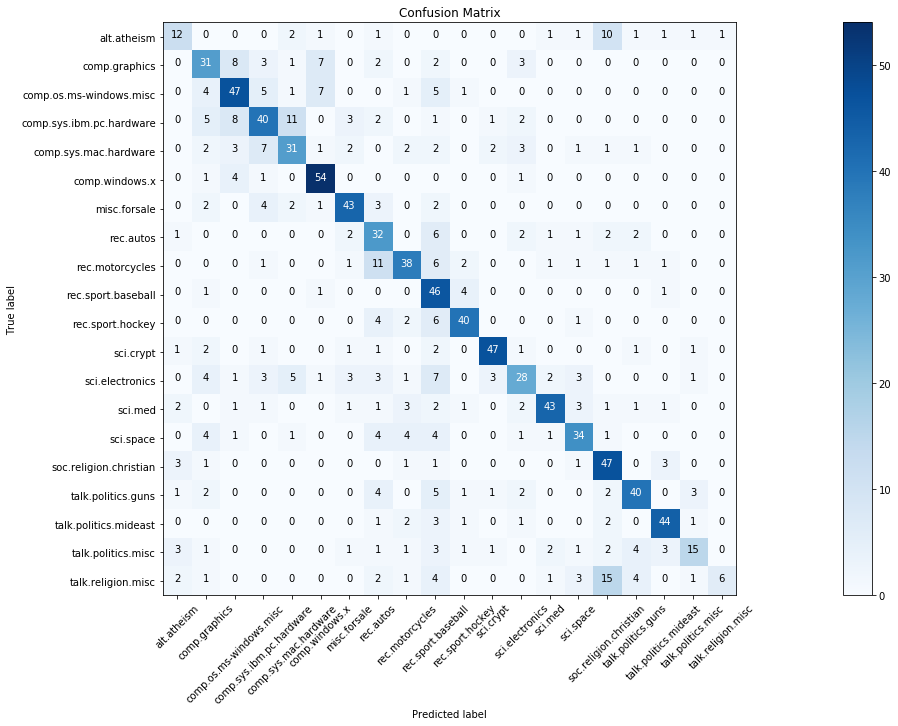

In [21]:
cnf_matrix = confusion_matrix(y_validation.todense(), clf.predict(x_validation.todense()))
np.set_printoptions(precision=2)

plt.figure(figsize=(30,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroup.target_names, title='Confusion Matrix')

`From confusion matrix precision an recall values can be derived for each class.`
`For instance these values for` **`graphics`** `class is as follows.`

$recall = \frac{Number of True Positives}{Number of Actual Graphics} = \frac{31}{57} = 0.543$

$precision = \frac{Number of True Positives}{Number of Predicted Graphics} = \frac{31}{61} = 0.508$

### `Inspect the` *`feature_importances`*  `attribute of the Random Forest model`

In [22]:
n_01 = 0
n_001 = 0
n_0001 = 0
n_00001 = 0
n_000001 = 0

for i in np.array(clf.feature_importances_):
    if i > 0.001:
        n_001 += 1
    if i > 0.0001:
        n_0001 += 1
    if i > 0.00001:
        n_00001 += 1
    if i > 0.000001:
        n_000001 += 1

In [23]:
print('There are %d TF-IDF features in total'%len(clf.feature_importances_))
print('%d of them bigger than 0.01'%n_01)
print('%d of them bigger than 0.001'%n_001)
print('%d of them bigger than 0.0001'%n_0001)
print('%d of them bigger than 0.00001'%n_00001)
print('%d of them bigger than 0.000001'%n_000001)
print('And %d of them smaller than 0.000001'%(len(clf.feature_importances_)-n_000001))

There are 101631 TF-IDF features in total
0 of them bigger than 0.01
145 of them bigger than 0.001
1738 of them bigger than 0.0001
9257 of them bigger than 0.00001
25331 of them bigger than 0.000001
And 76300 of them smaller than 0.000001


`As it can be derived from these values, most of the features are not hold significant weights. Only 149 out of 101.631 features (that are words) have an noticable impact on the model while predicting class. This can be interpreted as follows. There are only number of words that is actually (highly) distinguishing for classes and most of the words are just words that doesn't really give information about the class of the article. It is highly possible that most of such words are just stop words and not really domain specific (e.g. the, a, an, I, am, he, she, they, in, on, between). On the other hand, the most significant 149 words should be words that are highly realted to the classes of articles (e.g. drive, BMW, Mercedes, speed, road).`